In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from tqdm import tqdm

# Number of data points
NUM_SAMPLES = 1000

# True Kinetic parameters
# MU_MAX = 0.86980       # 1/h
# K_S    = 0.000123762       # g/l
# Y_XS   = 0.4357       # g/g

S_F    = 1.43 * 200  # g/l
K_I    = 33           # g/l
k_d    = 0.03        # 1/h

# --- Model parameters estimated using PINN ---
MU_MAX = 0.8564
K_S    = 0.1707
Y_XS   = 0.4066

# Noise parameters
BIOMASS_NOISE = 0.005
SUBSTRATE_NOISE = 0.003

# Initial Conditions
X_0, S_0, V_0 = 5, 0.013, 1.7  # Biomass, Substrate, Volume

# ODE solver parameters
ODE_SOLVER = 'RK23'

# Time parameters
T_START = 0
T_END = 10
TIME_RANGE = int(T_END - T_START) # Absolute time 

# Actual system dynamics
def actual_system(t: float, y: float, F: float):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]
    
# System dynamics
def system_dynamics(t, y, F) -> np.array:
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

def solve_ode(ode: callable, t_span: list, y0: list, method: str, t_eval: list, args: tuple) -> solve_ivp:
    sol = solve_ivp(ode, t_span=t_span, y0=y0, method=method, args=args, t_eval=t_eval, rtol=1e-6, atol=1e-12)
    # sol.y = np.maximum(sol.y, 0)
    return sol

def plot_solution(sol: solve_ivp) -> None:
    plt.figure(figsize=(12,4))
    plt.plot(sol.t, sol.y[0], label='Biomass')
    plt.plot(sol.t, sol.y[1], label='Substrate')
    plt.xlabel('Time (h)')
    plt.ylabel('Concentration (g/l)')
    plt.legend()
    plt.show()

In [2]:
# MPC parameters
dt = 0.5                         # Time step
L = int(TIME_RANGE / dt)       # Number of steps
N_p = 5                         # Prediction horizon
Q = 1.5                         # Weight for tracking
R = 0.5                            # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'COBYLA' # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 1.0                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# X_setpoint
X_sp = 30

print(f'Number of steps: {L} and dt: {dt}')

Number of steps: 20 and dt: 0.5


In [3]:
# ----- Cost function -----
def cost_function(F_opt: list, X: float, S: float, V: float) -> float:
    J = 0
    for k in range(N_p):
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X, S, V], method=ODE_SOLVER, t_eval=[dt], args=(F_opt[k],))      
        X_next = sol.y[0][-1]
        S_next = sol.y[1][-1]
        V_next = sol.y[2][-1]
        J += Q * (X_sp - X_next) ** 2
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2
        X, S, V = X_next, S_next, V_next
    
    return J

In [4]:
X = np.zeros(L)
S = np.zeros(L)
V = np.zeros(L)
F = np.zeros(L)
X[0], S[0], V[0] = X_0, S_0, V_0

def substrate_constraint(F_opt, X, S, V, current_time):
    X_curr, S_curr, V_curr = X, S, V
    substrate_log = []
    for k in range(N_p):
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X_curr, S_curr, V_curr], method=ODE_SOLVER, t_eval=[dt], args=(F_opt[k],))
        X_next = sol.y[0][-1]
        S_next = sol.y[1][-1]
        V_next = sol.y[2][-1]
        substrate_log.append(S_next)
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    
    return 5 - max(substrate_log)

USE_ACTUAL_DYNAMICS = True
for i in tqdm(range(L-1)):
    current_time = i * dt
    res = minimize(cost_function, np.zeros(N_p), args=(X[i], S[i], V[i]), bounds=BOUNDS, 
                   constraints={'type': 'ineq', 'fun': lambda F_opt: substrate_constraint(F_opt, X[i], S[i], V[i], current_time)},
                   method=OPTIMIZATION_METHOD)

    F_new = res.x[0]
    F[i+1] = F_new
    
    if USE_ACTUAL_DYNAMICS:
        # Use actual system dynamics
        sol = solve_ode(actual_system, t_span=[0, dt], y0=[X[i], S[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
        # Add "measurement noise" to the solution
        X[i+1] = sol.y[0][-1] + np.random.normal(0, max(0, sol.y[0][-1]) * BIOMASS_NOISE)
        S[i+1] = sol.y[1][-1] + np.random.normal(0, max(0, sol.y[1][-1]) * SUBSTRATE_NOISE)
        V[i+1] = sol.y[2][-1]
    else:
        # Use system dynamics
        sol = solve_ode(system_dynamics, t_span=[0, dt], y0=[X[i], S[i], V[i]], method=ODE_SOLVER, t_eval=[dt], args=(F_new,))
        X[i+1] = sol.y[0][-1] + np.random.normal(0, max(0, sol.y[0][-1]) * BIOMASS_NOISE)
        S[i+1] = sol.y[1][-1] + np.random.normal(0, max(0, sol.y[1][-1]) * SUBSTRATE_NOISE)
        V[i+1] = sol.y[2][-1]

100%|██████████| 19/19 [01:15<00:00,  3.98s/it]


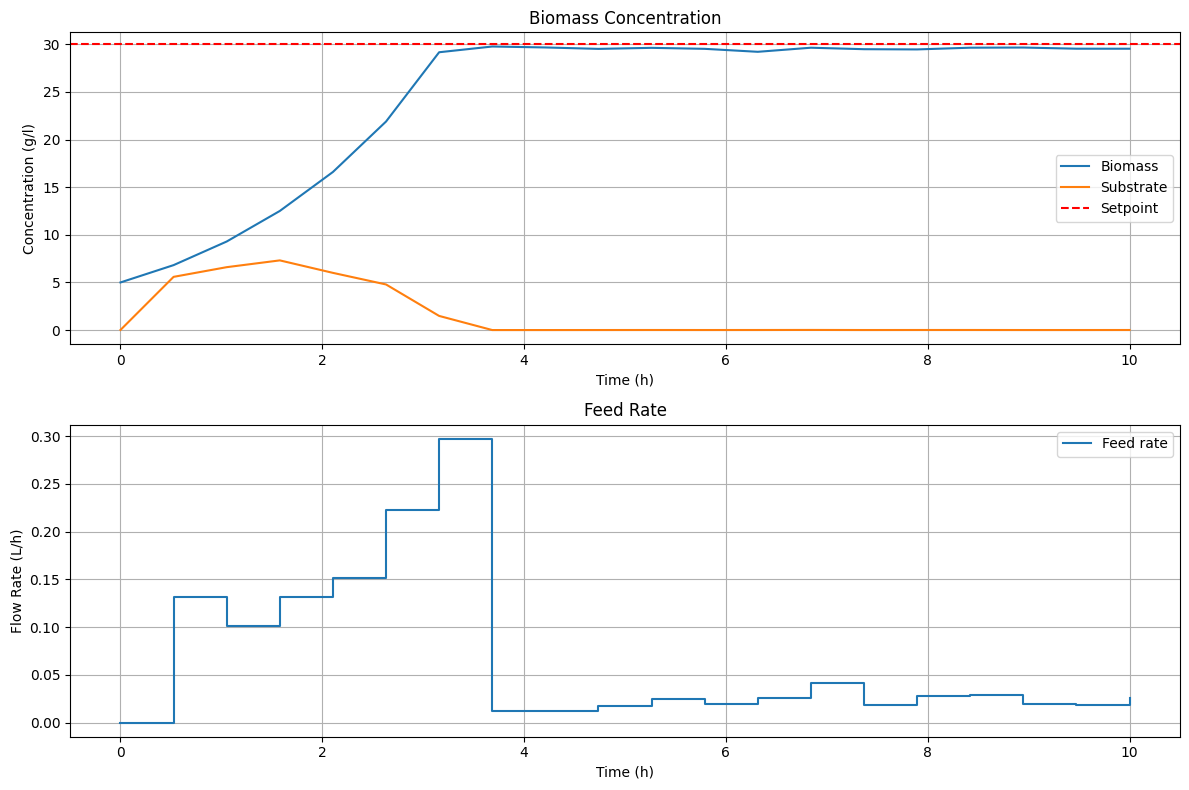

In [5]:
time= np.linspace(T_START, T_END, L)
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
plt.plot(time, X, label='Biomass')
plt.plot(time, S, label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.title('Biomass Concentration')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.step(time, F, label='Feed rate', where='post')
plt.title('Feed Rate')
plt.xlabel('Time (h)')
plt.ylabel('Flow Rate (L/h)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Evaluate using real system dynamics

/home/kostasme/.kostas/lib/python3.11/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `atols`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


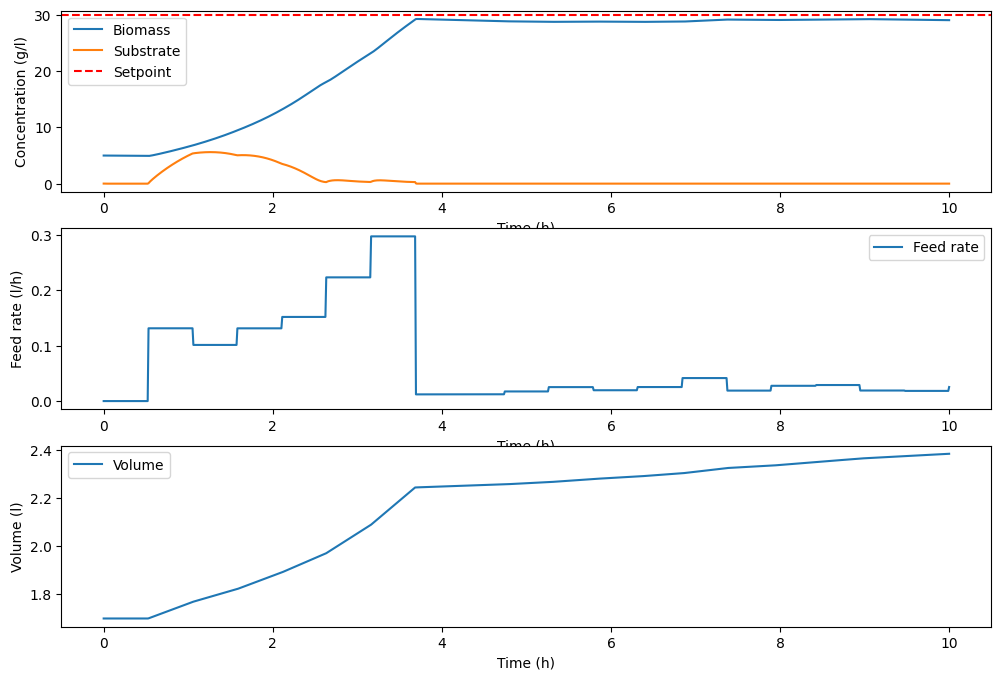

In [6]:
from scipy.interpolate import interp1d

# System dynamics
def simulate(t, y, F_func) -> np.array:
    
    F = F_func(t)   
    
    X, S, V = y
    dX_dt = (MU_MAX * S / (K_S + S + S**2 / K_I)) * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt,dV_dt])

# Actual system dynamics
def actual_system(t: float, y: float, F: float):
    ''' Real system model with cell death and substrate inhibition '''
    X, S, V = y
    mu = MU_MAX * S / (K_S + S + S**2 / K_I)  # Monod equation
    dX_dt = mu * X - (F / V) * X - k_d * X
    dS_dt = -(1 / Y_XS) * mu * X + (F / V) * (S_F - S) 
    dV_dt = F
    return [dX_dt, dS_dt, dV_dt]


F_func = interp1d(time, F, kind='previous', fill_value='extrapolate')
t_eval = np.linspace(T_START, T_END, NUM_SAMPLES)
sol = solve_ivp(simulate, t_span=[T_START, T_END], y0=[X_0, S_0, V_0], method=ODE_SOLVER, t_eval=t_eval, args=(F_func,), atols=1e-12, rtol=1e-12)

# Plot results
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(sol.t, sol.y[0], label='Biomass')
plt.plot(sol.t, sol.y[1], label='Substrate')
plt.axhline(y=X_sp, color='r', linestyle='--', label='Setpoint')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (g/l)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(sol.t, F_func(sol.t), label='Feed rate')
plt.xlabel('Time (h)')
plt.ylabel('Feed rate (l/h)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(sol.t, sol.y[2], label='Volume')
plt.xlabel('Time (h)')
plt.ylabel('Volume (l)')
plt.legend()
plt.show()